In [14]:
import pandas as pd
import xarray as xr
import glob
import os
import netCDF4
import scipy
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
#from oceans.filters import lanc  #pip install ocean
import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs

In [15]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

In [16]:
#/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc


region = 'NORTHSEA'

start_time = '01/01/2021'

end_time = '31/12/2021'

year = '2021'

if region in {'BALTIC'} :
    max_lat = 66.0
    min_lat = 53.0
    max_lon = 31.0
    min_lon = 9.0
    
    #tg_dac = xr.open_dataset('/nfs/DGFI8/H/work_marcello/giussani_machinelearning_data/TG_DACcorrected/baltic_tg_gesla_dac.nc')
    #tg_dac = xr.open_dataset('/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc')
    tg_dac = xr.open_dataset('/DGFI8/H/work_marcello/machine_learning_altimetry_validation/gesla_2021_selected_lowess_dac_correctedupdate_northsea.nc')

    lon = np.asarray(tg_dac.lon.values,dtype=float)
    lat = np.asarray(tg_dac.lat.values,dtype=float)    
    
#     # Exclude tide gauges in Kattegat and Skagerrag, because out of the training area

    indices =  ~( (lon < 13.0) & (lon > 9) &   \
                              (lat < 66.0) & (lat > 56.0)) & ((lon < max_lon) & (lon > min_lon) &   \
                              (lat < max_lat) & (lat > min_lat))   
    

    # Altimetry
    alti_full = pd.read_csv(r'/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_baltic2004_01to12.csv',index_col=[0],parse_dates=[0])
    
    #model
    copernicus_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_copernicus.csv',index_col=[7],parse_dates=[7])
    copernicus_full['sla_predicted'] = copernicus_full['sla_predicted'] 

    #cmems
    cmems_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_cmems_allsat.csv',index_col=[5],parse_dates=[5])    
    

elif region in {'NORTHSEA'} :
    
    max_lat = 61.0
    min_lat = 50.0
    max_lon = 12.2
    min_lon = -4.0  
    
    tg_dac = xr.open_dataset('/DGFI8/H/work_marcello/machine_learning_altimetry_validation/gesla_2021_selected_lowess_dac_correctedupdate_northsea.nc')
    #tg_dac = xr.open_dataset('/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc')
    
    try : 
        lon = np.asarray(tg_dac.lon.values,dtype=float)
        lat = np.asarray(tg_dac.lat.values,dtype=float)
    except:
        tg_dac = tg_dac.rename({'longitude': 'lon'})
        tg_dac = tg_dac.rename({'latitude': 'lat'})
        lon = np.asarray(tg_dac.lon.values,dtype=float)
        lat = np.asarray(tg_dac.lat.values,dtype=float)       
    
    indices =  ( (lon < max_lon) & (lon > min_lon) &   \
                              (lat < max_lat) & (lat > min_lat) )    

    # Use .where() method to select a subset of the data within the specified range
    tg_dac = tg_dac.where((tg_dac.lat >= min_lat) & (tg_dac.lat <= max_lat) & (tg_dac.lon >= min_lon) & (tg_dac.lon <= max_lon), drop=True)    
    
    # Altimetry
    alti_full = pd.read_csv(r'/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_northsea2021_01to12.csv',index_col=[0],parse_dates=[0])
    
    #model
    copernicus_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_copernicus.csv',index_col=[7],parse_dates=[7])
    copernicus_full['sla_predicted'] = copernicus_full['sla_predicted'] 

    #cmems
    cmems_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_cmems_NORTHSEA_allsat.csv',index_col=[5],parse_dates=[5])


try:
    tg_dac = tg_dac.sel({'x':indices })
except:
    tg_dac = tg_dac.rename({'station': 'index'})
    tg_dac = tg_dac.rename_dims({'index': 'x'})
    #tg_dac = tg_dac.reset_coords('x')
    #tg_dac = tg_dac.rename_dims({'station': 'x'})
    tg_dac = tg_dac.rename({'date_time': 'time'})
    tg_dac = tg_dac.assign_coords(lon=tg_dac.lon)
    tg_dac = tg_dac.assign_coords(lat=tg_dac.lat)
    tg_dac = tg_dac.rename({'sla_dac': 'sla'})
    tg_dac = tg_dac.transpose('time', 'x')
    #tg_dac = tg_dac.rename({'date_time': 'time'},coords={'date_time': 'time'})
    #tg_dac = tg_dac.rename({'x': 'index'})
    #tg_dac = tg_dac.sel({'x':indices })
    #tg_dac = tg_dac.sel({'station':indices })

tg_dac


<xarray.Dataset>
Dimensions:                  (time: 6207, x: 20)
Coordinates:
    lat                      (x) float64 57.14 51.39 51.95 ... 54.49 58.44 54.65
    lon                      (x) float64 -2.08 3.199 1.292 ... -3.086 -3.567
    index                    (x) int64 1 1160 20 9 4 21 5 ... 14 992 27 17 10 29
  * time                     (time) datetime64[ns] 2021-01-01T01:00:00 ... 20...
Dimensions without coordinates: x
Data variables: (12/29)
    sea_level                (time, x) float64 3.727 2.058 3.847 ... nan nan nan
    qc_flag                  (time, x) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    use_flag                 (time, x) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    filename                 (x) object 'aberdeen-abe-gbr-bodc' ... 'workingt...
    site_name                (x) object 'Aberdeen' ... 'Workington'
    site_code                (x) object 'ABE' 'Bol' 'HAR' ... 'WHI' 'WIC' 'WOR'
    ...                       ...
    gauge_type               (x) object 'Coastal' 'Coastal' ... 'Coastal'
    overall_record_quality   (x) object 'No obvious issues' ... 'No obvious i...
    sea_level_lowess         (time, x) float64 3.27 0.9358 2.157 ... nan nan nan
    dac                      (time, x) float64 nan nan nan nan ... nan nan nan
    sla                      (time, x) float64 nan nan nan nan ... nan nan nan
    sla_dac_no_loess         (time, x) float64 nan nan nan nan ... nan nan nan
Attributes:
    comment:  duplicates are rejected; longest TG record of a TG pair within ...

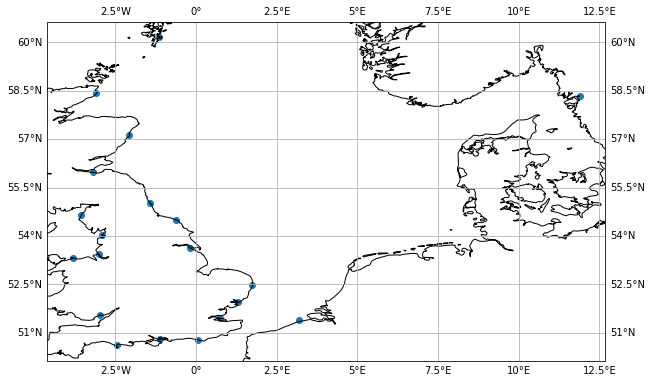

In [17]:
# Get the longitude and latitude coordinates
lon = tg_dac.lon.values
lat = tg_dac.lat.values

# Set up the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot the points
ax.scatter(lon, lat, transform=ccrs.PlateCarree())

# Show the plot
plt.show()

In [18]:
# Distance vs TG
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    
    
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 -lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

    return np.round(res, 2)

In [19]:
# print(data.keys())
# print(np.shape(data['time']))
# print(np.shape(data['sla_dac']))

/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(1)
Coordinates:
    lat      float64 57.14
    lon      float64 -2.08
    index    int64 1
             ML     cmems        TG
ML     1.000000  0.944941  0.435768
cmems  0.944941  1.000000  0.455599
TG     0.435768  0.455599  1.000000
RMSE ML TG
0.10712595507310302
RMSE CMEMS TG
0.10794069497363432


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(1160)
Coordinates:
    lat      float64 51.39
    lon      float64 3.199
    index    int64 1160
             ML     cmems        TG
ML     1.000000  0.712856  0.809479
cmems  0.712856  1.000000  0.616974
TG     0.809479  0.616974  1.000000
RMSE ML TG
0.08841659639815136
RMSE CMEMS TG
0.12839917663618383


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(20)
Coordinates:
    lat      float64 51.95
    lon      float64 1.292
    index    int64 20
             ML     cmems        TG
ML     1.000000  0.667297  0.713403
cmems  0.667297  1.000000  0.629996
TG     0.713403  0.629996  1.000000
RMSE ML TG
0.07269337717600764
RMSE CMEMS TG
0.10094079868142755


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(9)
Coordinates:
    lat      float64 54.03
    lon      float64 -2.92
    index    int64 9
             ML     cmems        TG
ML     1.000000  0.813000  0.503417
cmems  0.813000  1.000000  0.419178
TG     0.503417  0.419178  1.000000
RMSE ML TG
0.08517434626667313
RMSE CMEMS TG
0.0947636739069282


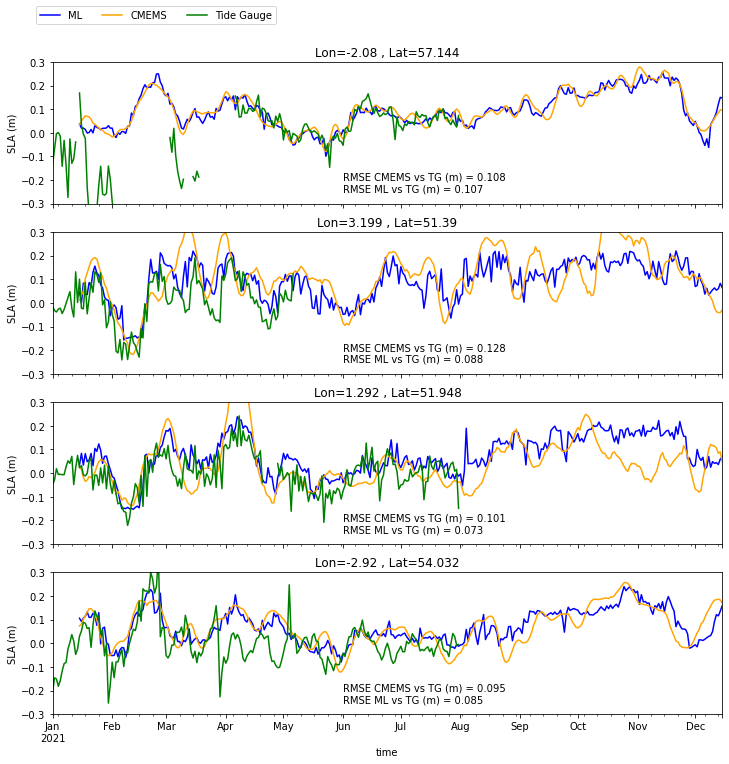

In [20]:
# FOR THE PAPER

# list_names = ['landsortnorra-010-sweden-smhi','gedser-gedser-denmark-dmi',\
#               'visby-026-sweden-smhi']

#list_names = ['skanor-019-sweden-smhi','kungsholmsfort-008-sweden-smhi',\
#              'simrishamn-017-sweden-smhi']

list_names = ['skanor-019-sweden-smhi']

corr_ML=np.empty(np.size(tg_dac.x))*np.nan
corr_cmems=np.empty(np.size(tg_dac.x))*np.nan

rms_ML=np.empty(np.size(tg_dac.x))*np.nan
rms_cmems=np.empty(np.size(tg_dac.x))*np.nan

std_ML=np.empty(np.size(tg_dac.x))*np.nan
std_cmems=np.empty(np.size(tg_dac.x))*np.nan
std_tg=np.empty(np.size(tg_dac.x))*np.nan


row_index = np.array([0,0,0])
#col_index = np.array([0,1,2])
col_index = np.arange(0,np.size(tg_dac.x))

fig, axs = plt.subplots(np.size(tg_dac.x[0:4]), 1, sharex=True, sharey=False, figsize=(12,12))

#fig_b, axs_b = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,12))

counter = 0


#for tide_gauge_name in list_names :

for count_TG in tg_dac.x[[0,1,2,3]] :


    start_lat = np.asarray(tg_dac.lat[count_TG].values,dtype=float)
    start_lon = np.asarray(tg_dac.lon[count_TG].values,dtype=float)

    tide_gauge_name = tg_dac.index[count_TG]
    tg_due = tg_dac
    

    # initialise data of lists.
#     if region in {'BALTIC'} :
#         data = {'time':tg_due.time.values,
#                 'sla_dac':np.squeeze(tg_due.sla_dac.values)}
#     else:
    data = {'time':tg_due.time.values,
            'sla_dac':tg_due.sla[:,count_TG]}    
    #break

    # Create DataFrame
    tg = pd.DataFrame(data)
    
    # Remove mean from the tide gauge
    mean_tg_due= tg["sla_dac"].mean()
    tg.sla_dac = tg.sla_dac - tg["sla_dac"].mean()    
    median_tg_due= tg["sla_dac"].median()
    mad_tg_due= tg["sla_dac"].mad()    
    
    # Remove outliers from the tide gauge    
    tg.loc[tg["sla_dac"] > median_tg_due+1.4826*2*mad_tg_due] = np.nan
    tg.loc[tg["sla_dac"] < median_tg_due-1.4826*2*mad_tg_due] = np.nan
    
    tg=tg.set_index(tg.time)
    tg=tg.loc[year+'-01-01':year+'-12-31']
    
    tg = tg.groupby(pd.Grouper(freq='24H')).mean()

    #means_tg = tg.groupby(pd.Grouper(freq='3H')).mean()
    
    

    

    #alti
    alti=alti_full.loc[year+'-01-15':year+'-12-15']
    cmems=cmems_full.loc[year+'-01-15':year+'-12-15']
    
    

    # Compute distances from tide gauges 
    
    distances_km = haversine_distance(start_lat, start_lon, alti.lat, alti.lon)
    distances_km_cmems = haversine_distance(start_lat, start_lon, cmems.lat, cmems.lon)

    alti['distances_km']=distances_km
    cmems['distances_km']=distances_km_cmems

    alti.dropna(subset = ["sla_predicted"], inplace=True)
    cmems.dropna(subset = ["sla_predicted"], inplace=True)
    

    #alti = alti[distances_km<radius_of_distance_km]
    #cmems = cmems[distances_km_cmems<radius_of_distance_km]
    
    
    alti = alti.loc[alti['distances_km'] == np.nanmin(alti['distances_km'])]
    cmems = cmems.loc[cmems['distances_km'] == np.nanmin(cmems['distances_km'])]
    #cmems = cmems.loc[np.abs(cmems['distances_km'] - np.nanmin(alti['distances_km']))<5]
    
    alti = alti.groupby(['time']).mean()
    cmems = cmems.groupby(['time']).mean()
    

#     if np.shape(tg.sla_dac.values[np.isnan(tg.sla_dac.values)])[0] > 60  :
#         if counter == 0 :
#             fig.legend()        
#         counter = counter + 1
#         continue        
    
    
    freq = 1./10  # Hours
    window_size = 60


    # Plot of the products
    try:
        ref = alti.sla_predicted.plot(ax=axs[col_index[counter]],label="ML",title='lon='+str(tide_gauge_name.lon.values)+' , '+'lat='+str(tide_gauge_name.lat.values),color='blue')
    except:
        pass

    try:
        cmems.sla_predicted.plot(ax=axs[col_index[counter]],label="CMEMS",color='orange')
    except:
        pass
    tg.sla_dac.plot(ax=axs[col_index[counter]],label="Tide Gauge",color='green')  
    
    ref.text(year+'-06-01',-0.25,'RMSE ML vs TG (m) = '+str( np.round( np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean()),3 ) ) )
    ref.text(year+'-06-01',-0.2,'RMSE CMEMS vs TG (m) = '+str( np.round( np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean()),3 ) ) )
    
    ref.set_ylabel("SLA (m)")
    
    ref.set_ylim(-0.3, 0.3)
    #ax.set_title("Title for first plot")
    ref.set_title('Lon='+str(np.round(tide_gauge_name.lon.values,3))+' , '+'Lat='+str(np.round(tide_gauge_name.lat.values,3)))
    if counter == 0 :
        fig.legend(bbox_to_anchor =(0.1, 0.95), ncol = 3,loc='upper left')
    

    
    #Correlation Analysis

    #HIGH RES

    data = [alti["sla_predicted"], cmems["sla_predicted"], tg["sla_dac"]]

    headers = ["ML", "cmems", "TG"]

    df = pd.concat(data, axis=1, keys=headers)

    correlation_df = df.corr()
    print(tide_gauge_name)
    print(correlation_df)
    
    

    
    print("RMSE ML TG")
    print(np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))
          
    print("RMSE CMEMS TG")
    print(np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))          
   
    corr_ML[count_TG]=correlation_df.values[0,2]
    corr_cmems[count_TG]=correlation_df.values[1,2]
    
    rms_ML[count_TG]=np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean())
    rms_cmems[count_TG]=np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean())   
    
    std_ML[count_TG]=scipy.stats.iqr(alti["sla_predicted"],nan_policy='omit')#np.rms(alti["sla_predicted"]) 
    std_cmems[count_TG]=  scipy.stats.iqr(cmems["sla_predicted"],nan_policy='omit')#np.rms(cmems["sla_predicted"])
    std_tg[count_TG]=  scipy.stats.iqr(tg["sla_dac"],nan_policy='omit')#np.rms(tg["sla_dac"])    
    
    counter = counter + 1
    
    #break

fig.savefig('fig_timeseriesexample_'+year+'.png')





In [21]:
correlation_df.values

array([[1.        , 0.81300023, 0.50341681],
       [0.81300023, 1.        , 0.41917815],
       [0.50341681, 0.41917815, 1.        ]])

/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

<xarray.DataArray 'index' ()>
array(20)
Coordinates:
    lat      float64 51.95
    lon      float64 1.292
    index    int64 20
             ML     cmems        TG
ML     1.000000  0.667297  0.713403
cmems  0.667297  1.000000  0.629996
TG     0.713403  0.629996  1.000000
RMSE ML TG
0.07269337717600764
RMSE CMEMS TG
0.10094079868142755


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(9)
Coordinates:
    lat      float64 54.03
    lon      float64 -2.92
    index    int64 9
             ML     cmems        TG
ML     1.000000  0.813000  0.503417
cmems  0.813000  1.000000  0.419178
TG     0.503417  0.419178  1.000000
RMSE ML TG
0.08517434626667313
RMSE CMEMS TG
0.0947636739069282


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

<xarray.DataArray 'index' ()>
array(21)
Coordinates:
    lat      float64 55.99
    lon      float64 -3.182
    index    int64 21
             ML     cmems        TG
ML     1.000000  0.910054  0.736007
cmems  0.910054  1.000000  0.758330
TG     0.736007  0.758330  1.000000
RMSE ML TG
0.08028010642183592
RMSE CMEMS TG
0.0741735769768886


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(5)
Coordinates:
    lat      float64 60.15
    lon      float64 -1.14
    index    int64 5
             ML     cmems        TG
ML     1.000000  0.943674  0.696600
cmems  0.943674  1.000000  0.696434
TG     0.696600  0.696434  1.000000
RMSE ML TG
0.06231293783309064
RMSE CMEMS TG
0.06137786809605544


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

<xarray.DataArray 'index' ()>
array(31)
Coordinates:
    lat      float64 53.33
    lon      float64 -3.825
    index    int64 31
             ML     cmems        TG
ML     1.000000  0.868144  0.550372
cmems  0.868144  1.000000  0.472762
TG     0.550372  0.472762  1.000000
RMSE ML TG
0.09345906900848258
RMSE CMEMS TG
0.09713505774581177


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(8)
Coordinates:
    lat      float64 52.47
    lon      float64 1.75
    index    int64 8
             ML     cmems        TG
ML     1.000000  0.924137  0.755083
cmems  0.924137  1.000000  0.739439
TG     0.755083  0.739439  1.000000
RMSE ML TG
0.08310368188837444
RMSE CMEMS TG
0.1027593806196803


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(19)
Coordinates:
    lat      float64 50.78
    lon      float64 0.05703
    index    int64 19
             ML     cmems        TG
ML     1.000000  0.689970  0.381708
cmems  0.689970  1.000000  0.268625
TG     0.381708  0.268625  1.000000
RMSE ML TG
0.06292246203408289
RMSE CMEMS TG
0.08406263830737758


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

<xarray.DataArray 'index' ()>
array(3)
Coordinates:
    lat      float64 55.01
    lon      float64 -1.44
    index    int64 3
             ML     cmems        TG
ML     1.000000  0.945719  0.672731
cmems  0.945719  1.000000  0.664222
TG     0.672731  0.664222  1.000000
RMSE ML TG
0.08736761220698934
RMSE CMEMS TG
0.08930219181066046


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

<xarray.DataArray 'index' ()>
array(10)
Coordinates:
    lat      float64 58.44
    lon      float64 -3.086
    index    int64 10
             ML     cmems        TG
ML     1.000000  0.910656  0.781773
cmems  0.910656  1.000000  0.745269
TG     0.781773  0.745269  1.000000
RMSE ML TG
0.06728756224813796
RMSE CMEMS TG
0.07794543443761624


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(29)
Coordinates:
    lat      float64 54.65
    lon      float64 -3.567
    index    int64 29
             ML     cmems        TG
ML     1.000000  0.826590  0.647108
cmems  0.826590  1.000000  0.519821
TG     0.647108  0.519821  1.000000
RMSE ML TG
0.08960457031238427
RMSE CMEMS TG
0.1121927733998165


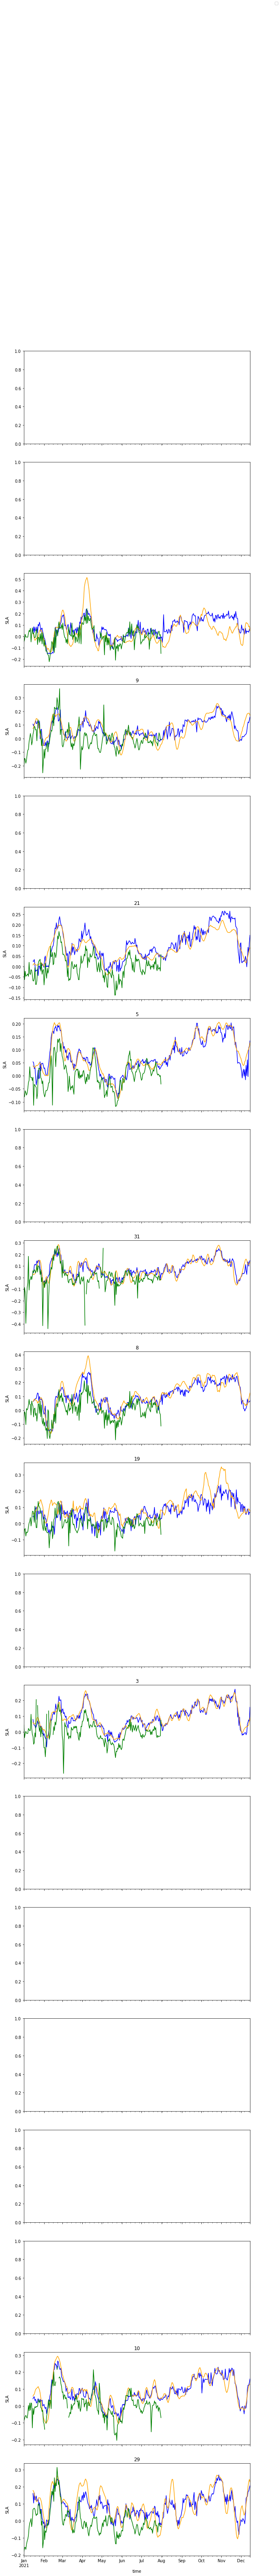

In [22]:
# list_names = ['landsortnorra-010-sweden-smhi','gedser-gedser-denmark-dmi',\
#               'visby-026-sweden-smhi']

#list_names = ['skanor-019-sweden-smhi','kungsholmsfort-008-sweden-smhi',\
#              'simrishamn-017-sweden-smhi']

list_names = ['skanor-019-sweden-smhi']

corr_ML=np.empty(np.size(tg_dac.x))*np.nan
corr_cmems=np.empty(np.size(tg_dac.x))*np.nan

rms_ML=np.empty(np.size(tg_dac.x))*np.nan
rms_cmems=np.empty(np.size(tg_dac.x))*np.nan

std_ML=np.empty(np.size(tg_dac.x))*np.nan
std_cmems=np.empty(np.size(tg_dac.x))*np.nan
std_tg=np.empty(np.size(tg_dac.x))*np.nan


row_index = np.array([0,0,0])
#col_index = np.array([0,1,2])
col_index = np.arange(0,np.size(tg_dac.x))

fig, axs = plt.subplots(np.size(tg_dac.x), 1, sharex=True, sharey=False, figsize=(10,100))

#fig_b, axs_b = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,12))

counter = 0


#for tide_gauge_name in list_names :

for count_TG in tg_dac.x[0:] :

    #radius_of_distance_km = 100
    #tide_gauge_name='visby-026-sweden-smhi'
    
    start_lat = np.asarray(tg_dac.lat[count_TG].values,dtype=float)
    start_lon = np.asarray(tg_dac.lon[count_TG].values,dtype=float)

#     if region in {'BALTIC'} :
#         tide_gauge_name = tg_dac.name[count_TG]
#         tg_due = tg_dac.where(tg_dac.name==tide_gauge_name, drop=True)
#         tide_gauge_name = tg_dac.name[count_TG]
#     else:
    tide_gauge_name = tg_dac.index[count_TG]
    tg_due = tg_dac
    

    ## TIDE CORRECTION

    # dates = []

    # for j in range(-1,24*28*365+5):
    #      dates.append(np.array([datetime(1993, 1, 1, 0, 0, 0) + 
    # timedelta(hours=1+j)]))

    # dates = np.ravel(dates)

    # plt.figure(figsize=(15,5),dpi=320)

    # tide_correction_fes = pd.read_csv("/DGFI8/H/work_marcello/giussani_machinelearning_data/TG/landsortnorra-010-sweden-smhi_fes_ocean.txt",header=None)/100

    # plt.plot(dates,tide_correction_fes,)

    # plt.plot(tg_due.date_time,tg_due.sealevel-tide_correction_fes)
    # plt.ylabel('m')




    # initialise data of lists.
#     if region in {'BALTIC'} :
#         data = {'time':tg_due.time.values,
#                 'sla_dac':np.squeeze(tg_due.sla_dac.values)}
#     else:
    data = {'time':tg_due.time.values,
            'sla_dac':tg_due.sla[:,count_TG]}    
    #break

    # Create DataFrame
    tg = pd.DataFrame(data)
    
    # Remove mean from the tide gauge
    mean_tg_due= tg["sla_dac"].mean()
    tg.sla_dac = tg.sla_dac - tg["sla_dac"].mean()    
    median_tg_due= tg["sla_dac"].median()
    mad_tg_due= tg["sla_dac"].mad()    
    
    # Remove outliers from the tide gauge    
    tg.loc[tg["sla_dac"] > median_tg_due+1.4826*2*mad_tg_due] = np.nan
    tg.loc[tg["sla_dac"] < median_tg_due-1.4826*2*mad_tg_due] = np.nan
    
    tg=tg.set_index(tg.time)
    tg=tg.loc[year+'-01-01':year+'-12-31']
    
    tg = tg.groupby(pd.Grouper(freq='24H')).mean()

    #means_tg = tg.groupby(pd.Grouper(freq='3H')).mean()
    
    

    

    #alti
    alti=alti_full.loc[year+'-01-15':year+'-12-15']
    #alti_only2004=alti_only2004.loc[year+'-11-20':year+'-11-29']
    cmems=cmems_full.loc[year+'-01-15':year+'-12-15']
    
    

    # Compute distances from tide gauges 
    
    distances_km = haversine_distance(start_lat, start_lon, alti.lat, alti.lon)
    #distances_km_only2004 = haversine_distance(start_lat, start_lon, alti_only2004.lat, alti_only2004.lon)
    distances_km_cmems = haversine_distance(start_lat, start_lon, cmems.lat, cmems.lon)

    alti['distances_km']=distances_km
    #alti_only2004['distances_km']=distances_km
    cmems['distances_km']=distances_km_cmems

    alti.dropna(subset = ["sla_predicted"], inplace=True)
    cmems.dropna(subset = ["sla_predicted"], inplace=True)
    

    #alti = alti[distances_km<radius_of_distance_km]
    #cmems = cmems[distances_km_cmems<radius_of_distance_km]
    
    
    alti = alti.loc[alti['distances_km'] == np.nanmin(alti['distances_km'])]
    cmems = cmems.loc[cmems['distances_km'] == np.nanmin(cmems['distances_km'])]
    #cmems = cmems.loc[np.abs(cmems['distances_km'] - np.nanmin(alti['distances_km']))<5]
    
    

#     alti = alti.loc[alti['distances_km'] <20]
#     cmems = cmems.loc[cmems['distances_km'] <20]
 
    
    #alti = alti.iloc[[np.nanargmin(distances_km)]]
    #cmems = cmems.iloc[[np.nanargmin(distances_km_cmems)]]


    alti = alti.groupby(['time']).mean()
    cmems = cmems.groupby(['time']).mean()
    
    
    #Check that time series are not too short and that they have a similar number of data
    if np.shape(alti)[0] < 120 or np.shape(cmems)[0] < 120 or np.shape(tg.sla_dac)[0]<120 or np.shape(tg.sla_dac.values[np.isnan(tg.sla_dac.values)])[0] > 60  :
        if counter == 0 :
            fig.legend()        
        counter = counter + 1
        continue
        
    if np.shape(tg.sla_dac.values[np.isnan(tg.sla_dac.values)])[0] > 60  :
        if counter == 0 :
            fig.legend()        
        counter = counter + 1
        continue        
    
    
    freq = 1./10  # Hours
    window_size = 60
    


    
    # LOESS FILTER IN TIME
#     lowess_sm = sm.nonparametric.lowess
#     points_to_filter = 10 #100 points along-track correspond to about 60 km
#     frac_loess = points_to_filter/np.size(alti.sla_predicted)
#     alti.sla_predicted = lowess_sm(np.asarray(alti.sla_predicted),np.asarray(alti.times),frac=frac_loess,it=3, return_sorted = False,missing='drop')
#     cmems.sla_predicted = lowess_sm(np.asarray(cmems.sla_predicted),np.asarray(cmems.times),frac=frac_loess,it=3, return_sorted = False,missing='drop')
    

    # Oversample daily cmems to hourly values
    #cmems_oversample = cmems
    #cmems_oversample = cmems.resample('3H').pad()
    
    
#     means_alti = alti.groupby(pd.Grouper(freq='24H')).mean()
#     means_alti.sla_predicted = np.convolve(means_alti.sla_predicted, np.ones(7)/7, mode='same')
    
#     means_cmems  = cmems.groupby(pd.Grouper(freq='24H')).mean()
#     means_tg = tg.groupby(pd.Grouper(freq='24H')).mean()    
    

    # Plot of the products
    try:
        ref = alti.sla_predicted.plot(ax=axs[col_index[counter]],label="ML",title=tide_gauge_name.values,color='blue')
    except:
        pass
    try:
        cmems.sla_predicted.plot(ax=axs[col_index[counter]],label="cmems altimetry",color='orange')
    except:
        pass
    tg.sla_dac.plot(ax=axs[col_index[counter]],label="tide gauge",color='green')  
    ref.set_ylabel("SLA")
    if counter == 0 :
        fig.legend()
    
    
    
    


    # Plot of the daily products
#     means_alti.sla_predicted.plot(ax=axs[row_index[counter],col_index[counter]],label="ML")
#     means_cmems.sla_predicted.plot(ax=axs[row_index[counter],col_index[counter]],label="cmems altimetry")
#     means_tg.sealevel.plot(ax=axs[row_index[counter],col_index[counter]],label="tide gauge")
#     if counter == 0 :
#         fig.legend()
    
    
    
    #Correlation Analysis

    #HIGH RES

    data = [alti["sla_predicted"], cmems["sla_predicted"], tg["sla_dac"]]

    headers = ["ML", "cmems", "TG"]

    df = pd.concat(data, axis=1, keys=headers)

    #df = {'alti': np.asarray(alti.sla_predicted), 'copernicus': np.asarray(copernicus.sla_predicted), 'tg': np.asarray(tg.sealevel)}
    correlation_df = df.corr()
    print(tide_gauge_name)
    print(correlation_df)
    
    

    
    print("RMSE ML TG")
    print(np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))
          
    print("RMSE CMEMS TG")
    print(np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))          
   
    corr_ML[count_TG]=correlation_df.values[0,2]
    corr_cmems[count_TG]=correlation_df.values[1,2]
    
    rms_ML[count_TG]=np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean())
    rms_cmems[count_TG]=np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean())  
    
#     stddiff_ML[count_TG]=np.std(alti["sla_predicted"]) - np.std(tg["sla_dac"]) 
#     stddiff_cmems[count_TG]=  np.std(cmems["sla_predicted"]) - np.std(tg["sla_dac"])    
    
    std_ML[count_TG]=scipy.stats.iqr(alti["sla_predicted"],nan_policy='omit')#np.rms(alti["sla_predicted"]) 
    std_cmems[count_TG]=  scipy.stats.iqr(cmems["sla_predicted"],nan_policy='omit')#np.rms(cmems["sla_predicted"])
    std_tg[count_TG]=  scipy.stats.iqr(tg["sla_dac"],nan_policy='omit')#np.rms(tg["sla_dac"])    
    
    counter = counter + 1
    
    #break
    

Mean difference in correlation ML - CMEMS (%)
12.171006414343458
Mean difference in RMS ML - CMEMS (%)
-11.238076894368604


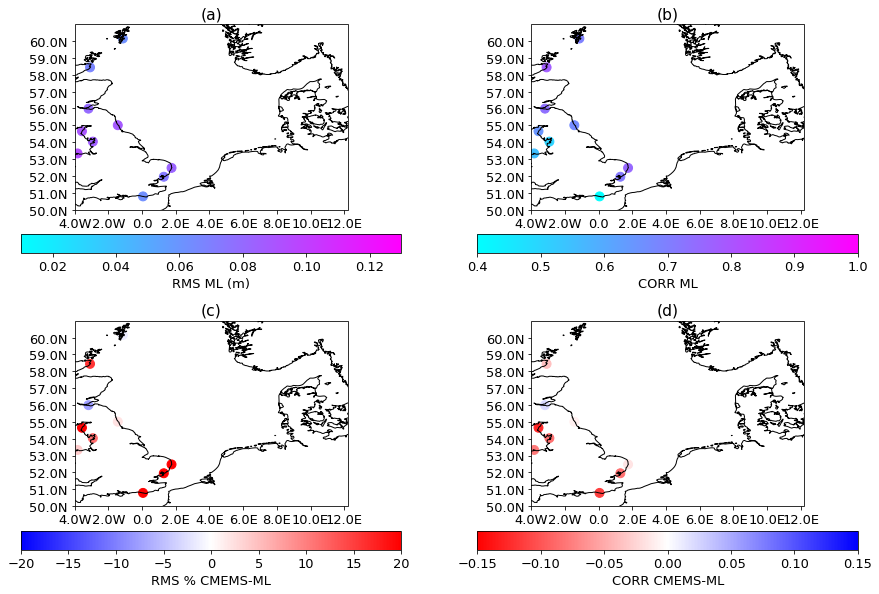

In [23]:
# FUNCTION TO PLOT SINGLE INSTANTANEOUS MAPS -  to be externalised

def single_plot(rms_cmemsvsML_plot,min_sl,max_sl,counter,row_total,col_total,fig,min_lat,max_lat,min_lon,max_lon,label_string,colormap):

    lon = rms_cmemsvsML_plot[0,:]
    lat = rms_cmemsvsML_plot[1,:]
    ssh = rms_cmemsvsML_plot[2,:]   
    
    """Displaying the unstructured grid in a scatterplot:"""
    # 

    #fig = plt.plot()
    #plt.rcParams.update({'font.size': 15})
    #plt.plot
    #plt.rcParams["figure.figsize"] = (50,10) #Increase figure size
    ax=fig.add_subplot(row_total,col_total,counter,projection=ccrs.PlateCarree())
    
    ax.set_xticks(np.arange(min_lon,max_lon,2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min_lat,max_lat,1), crs=ccrs.PlateCarree())    
    
    #ax = plt.axes(projection=ccrs.Miller()) 
    img=plt.scatter(lon, lat, c=ssh, s=80, cmap=colormap, alpha=1) 
    ax.coastlines(resolution='10m', color='black', linewidth=1) 
    plt.xlim(min_lon,max_lon)

    lon_formatter = cart.mpl.ticker.LongitudeFormatter(number_format='.1f', 
                                      degree_symbol='', 
                                      dateline_direction_label=True)
    lat_formatter = cart.mpl.ticker.LatitudeFormatter(number_format='.1f', 
                                     degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 
    plt.colorbar(img,label=label_string,orientation = 'horizontal',pad = 0.1)
    plt.clim(min_sl, max_sl)
    
    ax.set_extent([min_lon,max_lon,min_lat,max_lat,])
    #plt.show() #a window will show up, allowing the user to see and download the plot
    
    return 




# Corr and RMS of ML
rms_ML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),rms_ML,])
corr_ML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),corr_ML,])


# Absolute differences in RMS, Correlation and standard deviation
rms_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),rms_cmems-rms_ML,])
corr_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),corr_cmems-corr_ML,])

# Percentage differences in RMS and Correlation
rms_pc_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),((rms_cmems-rms_ML)/rms_ML)*100,])
corr_pc_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),((corr_cmems-corr_ML)/corr_ML)*100,])


fig = plt.figure(figsize = (15, 10))
plt.rcParams.update({'font.size': 13})

min_sl = 0.01
max_sl = 0.13
single_plot(rms_ML_plot,min_sl,max_sl,1,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'RMS ML (m)','cool')
plt.title('(a)')

min_sl = 0.4
max_sl = 1.0
single_plot(corr_ML_plot,min_sl,max_sl,2,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'CORR ML','cool')
plt.title('(b)')

# min_sl = -0.01
# max_sl = 0.01
# single_plot(rms_cmemsvsML_plot,min_sl,max_sl,3,3,2,fig,min_lat,max_lat,min_lon,max_lon,r'RMS CMEMS-ML (m)','bwr')

min_sl = -20
max_sl = 20
single_plot(rms_pc_cmemsvsML_plot,min_sl,max_sl,3,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'RMS % CMEMS-ML','bwr')
plt.title('(c)')


if region in {'BALTIC'} :
    min_sl = -0.05
    max_sl = 0.05
elif region in {'NORTHSEA'} :  
    min_sl = -0.15
    max_sl = 0.15    
    
single_plot(corr_cmemsvsML_plot,min_sl,max_sl,4,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'CORR CMEMS-ML','bwr_r')
plt.title('(d)')


# if region in {'BALTIC'} :
#     min_sl = -5
#     max_sl = 5
# elif region in {'NORTHSEA'} :
#     min_sl = -15
#     max_sl = 15
# single_plot(corr_pc_cmemsvsML_plot,min_sl,max_sl,6,3,2,fig,min_lat,max_lat,min_lon,max_lon,r'CORR % CMEMS-ML','bwr_r')


# Correlation
print('Mean difference in correlation ML - CMEMS (%)')
print(np.nanmean((corr_ML - corr_cmems) / corr_cmems * 100))

# RMS
print('Mean difference in RMS ML - CMEMS (%)')
print(np.nanmean((rms_ML - rms_cmems) / rms_cmems *100))

fig.savefig('fig_corr_rms_'+year+'.png')


Average misrepresented signal in ML (%)
36.55267776524962
Average misrepresented signal in CMEMS (%)
42.57343557747727


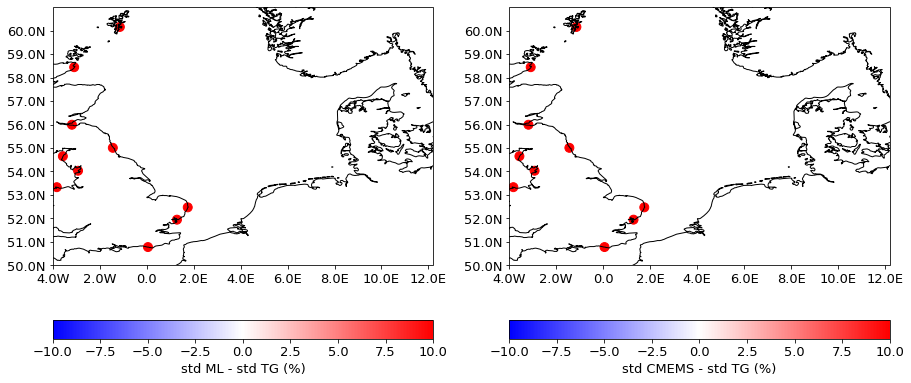

In [24]:
#Standard Deviations

stddiff_ML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),(std_ML-std_tg)/std_tg *100,])

stddiff_cmems_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),(std_cmems-std_tg)/std_tg *100,])


fig = plt.figure(figsize = (15, 10))

min_sl = -10
max_sl = 10
single_plot(stddiff_ML_plot ,min_sl,max_sl,1,1,2,fig,min_lat,max_lat,min_lon,max_lon,r'std ML - std TG (%)','bwr')


single_plot(stddiff_cmems_plot,min_sl,max_sl,2,1,2,fig,min_lat,max_lat,min_lon,max_lon,r'std CMEMS - std TG (%)','bwr')


print('Average misrepresented signal in ML (%)')
print(np.nanmean( (std_ML-std_tg)/std_tg *100)) 

print('Average misrepresented signal in CMEMS (%)')
print(np.nanmean( (std_cmems-std_tg)/std_tg *100) )




#### 

In [25]:
# Save the variability for use in other notebook
import pickle as pl
pl.dump(std_tg,file=open('std_tg_'+region+'_'+year+'.pickle','wb'))
pl.dump(std_ML,file=open('std_ML_'+region+'_'+year+'.pickle','wb'))
pl.dump(std_cmems,file=open('std_cmems_'+region+'_'+year+'.pickle','wb'))